# Experimentación

In [2]:
import copy
import numpy as np
import pandas as pd
from junifer.storage import HDF5FeatureStorage
import julearn
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging

from julearn.model_selection import RepeatedContinuousStratifiedKFold

configure_logging(level="INFO")

2024-06-07 08:31:38,894 - julearn - INFO - ===== Lib Versions =====
2024-06-07 08:31:38,896 - julearn - INFO - numpy: 1.26.4
2024-06-07 08:31:38,897 - julearn - INFO - scipy: 1.11.4
2024-06-07 08:31:38,898 - julearn - INFO - sklearn: 1.3.2
2024-06-07 08:31:38,900 - julearn - INFO - pandas: 2.2.1
2024-06-07 08:31:38,901 - julearn - INFO - julearn: 0.3.2
2024-06-07 08:31:38,903 - julearn - INFO - ========================


In [3]:
storage = HDF5FeatureStorage("./features/ds003097_GMD/ds003097_GMD.hdf5")

In [4]:
storage.list_features()

{'881ac4e46fc343c867f102ceb674fdff': {'datagrabber': {'class': 'PatternDataladDataGrabber',
   'patterns': {'VBM_GM': {'pattern': 'derivatives/fmriprep/{subject}/anat/{subject}_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz',
     'space': 'MNI152NLin2009cAsym'}},
   'replacements': ['subject'],
   'confounds_format': None,
   'types': ['VBM_GM'],
   'uri': 'https://github.com/OpenNeuroDatasets/ds003097.git',
   'datalad_dirty': False,
   'datalad_commit_id': '47f030747dbaf492acd9f9624528aef8d51d8bd9',
   'datalad_id': 'aefe5438-e93b-11ea-ad4c-8e2245da6db7'},
  'dependencies': {'nilearn': '0.10.2', 'numpy': '1.26.4'},
  'datareader': {'class': 'DefaultDataReader'},
  'type': 'VBM_GM',
  'marker': {'class': 'ParcelAggregation',
   'parcellation': ['Schaefer400x7'],
   'method': 'mean',
   'method_params': {},
   'masks': None,
   'name': 'Schaefer400x7_Mean',
   'time_method': None,
   'time_method_params': {}},
  '_element_keys': ['subject'],
  'name': 'VBM_GM_Schaefer400x7_Mean'},


In [5]:
# Cragando dataframe
df =storage.read_df("VBM_GM_Shen_2019_368_Mean")

In [6]:
# Cambiando etiquetas de las columnas
df_demografics = pd.read_csv("./data/participants.tsv", sep="\t")
df_demografics.rename(columns={"participant_id": "subject"}, inplace=True)

In [7]:
# Limpiando dataset
df.columns = df.columns.astype("str")
X = list(df.columns)
df_full = df.merge(df_demografics, on="subject")
df_full.dropna(inplace=True, subset=['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total'])
targets = ["IST_fluid", "IST_crystallised", "IST_memory"]

Separamos 10% de los datos para validación antes de entrenar los modelos

In [8]:
df_full.shape

(926, 399)

In [9]:
df_holdout = df_full.sample(frac=0.1, random_state=42)
df_holdout

,subject,1,2,3,4,5,6,7,8,9,...,sexual_attraction_M,sexual_attraction_F,gender_identity_M,gender_identity_F,religious_upbringing,religious_now,religious_importance,DWI_TR_run1,DWI_TR_run2,DWI_TR_run3
323,sub-0635,0.514908,0.549903,0.541406,0.514765,0.511887,0.491396,0.350862,0.424827,0.382222,...,2.0,6.0,2.0,5.0,no,no,NaN,6.311,6.311,6.311
601,sub-0503,0.499974,0.517306,0.542209,0.448822,0.534981,0.555862,0.335824,0.477757,0.425338,...,NaN,NaN,NaN,NaN,no,no,NaN,6.374,6.374,6.374
30,sub-0345,0.471175,0.525356,0.554896,0.375051,0.439218,0.536979,0.408894,0.317275,0.409072,...,6.0,2.0,1.0,7.0,no,no,NaN,6.311,6.311,6.311
825,sub-0454,0.439163,0.518745,0.521907,0.395653,0.479172,0.579434,0.410290,0.376543,0.459646,...,NaN,NaN,NaN,NaN,yes,no,NaN,6.311,6.312,6.312
294,sub-0249,0.472178,0.506438,0.519168,0.394832,0.499193,0.560724,0.370891,0.387456,0.417400,...,NaN,NaN,NaN,NaN,yes,no,NaN,6.312,6.313,6.313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,sub-0850,0.486701,0.535969,0.556655,0.462936,0.508814,0.489372,0.365765,0.435467,0.395467,...,7.0,2.0,1.0,7.0,no,no,NaN,6.311,6.311,6.311
60,sub-0404,0.524086,0.561566,0.661606,0.478921,0.557874,0.559515,0.413938,0.435262,0.482556,...,7.0,1.0,2.0,5.0,yes,no,NaN,6.374,6.374,6.374
803,sub-0222,0.372856,0.496878,0.523030,0.448043,0.455269,0.459995,0.351385,0.392032,0.408869,...,1.0,7.0,7.0,1.0,yes,no,NaN,6.311,6.311,6.311
660,sub-0709,0.564245,0.578342,0.601177,0.491050,0.482314,0.565333,0.416673,0.493292,0.427446,...,NaN,NaN,NaN,NaN,no,no,NaN,6.311,6.312,6.312


In [10]:
# Separando holdset de training set
df_full.drop(df_holdout.index, inplace=True)
df_full.shape

(833, 399)

### Correlación entre los targets

<Axes: >

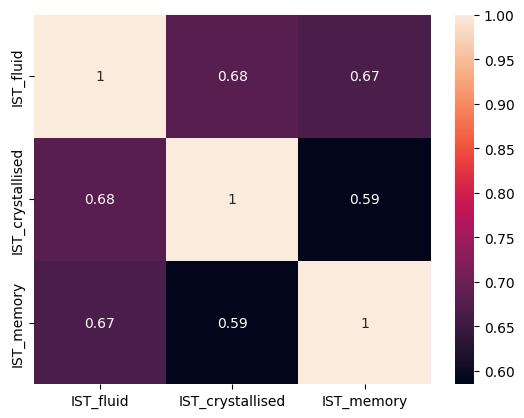

In [11]:
#correlation map of the 3 features to predict. IST_fluid, IST_crystallised, IST_memory
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_full[targets].corr(), annot=True)

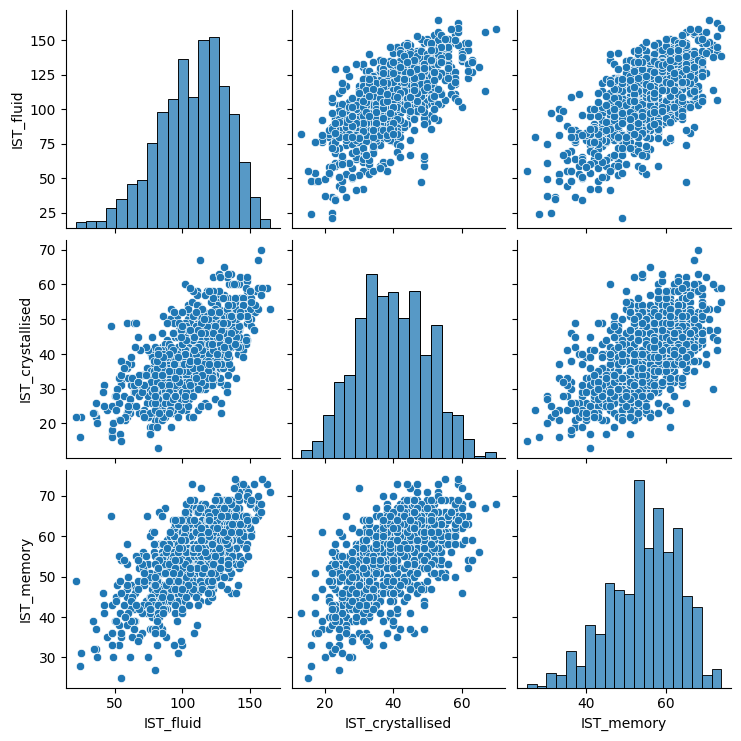

In [12]:
# Pairplot of the 3 features to predict. Correlation and distribution of the targets and the total

sns.pairplot(df_full[["IST_fluid", "IST_crystallised", "IST_memory"]])

### Entrenamiento

In [13]:
cv = RepeatedContinuousStratifiedKFold(3, n_splits=3, n_repeats=10, random_state=42)

In [14]:
search_params = {
    "kind": "bayes",
    "n_iter": 50,
}

# Model 1 (SVM)
creator1 = PipelineCreator(problem_type="regression")
creator1.add("zscore")
creator1.add("svm",
             kernel="linear",
             C=(1e-6, 1, "log-uniform"),
             epsilon=(0.01, 3, "log-uniform")
            )

creator2 = PipelineCreator(problem_type="regression")
creator2.add("zscore")
creator2.add("svm", 
             kernel=["rbf", "sigmoid"],
             C=(1e-6, 1, "log-uniform"),
             gamma=[1e-5, 1e-4, 1e-3, 1e-2, "scale", "auto"],
             epsilon=(0.01, 3, "log-uniform")
            )

# Model 2 (Random Forest)
creator3 = PipelineCreator(problem_type="regression")
creator3.add("zscore")
creator3.add("rf", n_estimators=[25, 50, 100], max_depth=[5, 10, 20])

# Model 3 (Gradient Boosting)
creatorXG = PipelineCreator(problem_type="regression")
creatorXG.add("zscore")
creatorXG.add("gradientboost", n_estimators=[25, 50, 100], max_depth=[3, 5, 10], random_state=42)

# Model 4 (Dummy)
dummy_creator = PipelineCreator(problem_type="regression")
dummy_creator.add("zscore")
dummy_creator.add("dummy")

2024-06-07 08:31:40,745 - julearn - INFO - Adding step zscore that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-07 08:31:40,748 - julearn - INFO - Step added
2024-06-07 08:31:40,751 - julearn - INFO - Adding step svm that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-07 08:31:40,752 - julearn - INFO - Setting hyperparameter kernel = linear
2024-06-07 08:31:40,754 - julearn - INFO - Tuning hyperparameter C = (1e-06, 1, 'log-uniform')
2024-06-07 08:31:40,756 - julearn - INFO - Tuning hyperparameter epsilon = (0.01, 3, 'log-uniform')
2024-06-07 08:31:40,758 - julearn - INFO - Step added
2024-06-07 08:31:40,760 - julearn - INFO - Adding step zscore that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-07 08:31:40,761 - julearn - INFO - Step added
2024-06-07 08:31:40,762 - julearn - INFO - Adding step svm that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:typ

In [15]:
scores_dict = {t: {} for t in targets}
model_dict = {t: {} for t in targets}
inspector_dict = {t: {} for t in targets}

models = {'SVM': [creator1, creator2], 'RF': creator3, 'XGBoost': creatorXG, 'Dummy': dummy_creator}

### Visualización

In [16]:
from julearn.viz import plot_scores

In [17]:
for y in targets:
    for m_name, m in models.items():
        scores, model, inspector = run_cross_validation(
            X=X,
            y=y,
            data=df_full,
            model= m,
            return_train_score=True,
            return_inspector=True,
            cv=cv,
            scoring="neg_mean_absolute_error",
            search_params=search_params if m_name == "SVM" else None,
        )
        scores['model'] = m_name
        scores_dict[y][m_name] = scores.copy()
        model_dict[y][m_name] = copy.deepcopy(model)
        inspector_dict[y][m_name] = copy.deepcopy(inspector)

2024-06-07 08:31:41,975 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-07 08:31:41,976 - julearn - INFO - ==== Input Data ====
2024-06-07 08:31:41,977 - julearn - INFO - Using dataframe as input
2024-06-07 08:31:41,980 - julearn - INFO - 	Features: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 08:31:42,034 - julearn - INFO - ====================
2024-06-07 08:31:42,035 - julearn - INFO - 
2024-06-07 08:31:42,039 - julearn - INFO - = Model Parameters =
2024-06-07 08:31:42,041 - julearn - INFO - Tuning hyperparameters using bayes
2024-06-07 08:31:42,042 - julearn - INFO - Hyperparameters:
2024-06-07 08:31:42,043 - julearn - INFO - 	svm__C: (1e-06, 1, 'log-uniform')
2024-06-07 08:31:42,045 - julearn - INFO - 	svm__epsilon: (0.01, 3, 'log-uniform')
2024-06-07 08:31:42,046 - julearn - INFO - Hyperparameter svm__C as is (1e-06, 1, 'log-uniform')
2024-06-07 08:31:42,048 - julearn - INFO - Hyperparameter svm__epsilon as is (0.01, 3, 'log-uniform')
2024-06-07 08:31:42,049 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 08:31:42,051 - julearn - INFO - Search Parameters:
2024-06-07 08:31:42,052 - julearn - INFO - 	n_iter: 50
2024-06-07 08:31:42,053 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=Fal

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 09:44:44,427 - julearn - INFO - ====================
2024-06-07 09:44:44,428 - julearn - INFO - 
2024-06-07 09:44:44,429 - julearn - INFO - = Model Parameters =
2024-06-07 09:44:44,430 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 09:44:44,431 - julearn - INFO - Hyperparameters:
2024-06-07 09:44:44,432 - julearn - INFO - 	rf__n_estimators: [25, 50, 100]
2024-06-07 09:44:44,433 - julearn - INFO - 	rf__max_depth: [5, 10, 20]
2024-06-07 09:44:44,433 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 09:44:44,434 - julearn - INFO - Search Parameters:
2024-06-07 09:44:44,435 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 09:44:44,436 - julearn - INFO - ====================
2024-06-07 09:44:44,437 - julearn - INFO - 
2024-06-07 09:44:44,438 - julearn - INFO - = Data Information =
2024-06-07 09:44:44,439 - julearn - INFO - 	Problem type: regression
2024-06-07 09:44:44,440 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 11:06:47,835 - julearn - INFO - ====================
2024-06-07 11:06:47,836 - julearn - INFO - 
2024-06-07 11:06:47,837 - julearn - INFO - = Model Parameters =
2024-06-07 11:06:47,838 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 11:06:47,839 - julearn - INFO - Hyperparameters:
2024-06-07 11:06:47,840 - julearn - INFO - 	gradientboost__n_estimators: [25, 50, 100]
2024-06-07 11:06:47,841 - julearn - INFO - 	gradientboost__max_depth: [3, 5, 10]
2024-06-07 11:06:47,842 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 11:06:47,842 - julearn - INFO - Search Parameters:
2024-06-07 11:06:47,843 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 11:06:47,844 - julearn - INFO - ====================
2024-06-07 11:06:47,845 - julearn - INFO - 
2024-06-07 11:06:47,846 - julearn - INFO - = Data Information =
2024-06-07 11:06:47,847 - julearn - INFO - 	Problem type: regression
202

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 12:38:46,685 - julearn - INFO - ====================
2024-06-07 12:38:46,686 - julearn - INFO - 
2024-06-07 12:38:46,688 - julearn - INFO - = Model Parameters =
2024-06-07 12:38:46,688 - julearn - INFO - ====================
2024-06-07 12:38:46,689 - julearn - INFO - 
2024-06-07 12:38:46,690 - julearn - INFO - = Data Information =
2024-06-07 12:38:46,691 - julearn - INFO - 	Problem type: regression
2024-06-07 12:38:46,692 - julearn - INFO - 	Number of samples: 833
2024-06-07 12:38:46,693 - julearn - INFO - 	Number of features: 368
2024-06-07 12:38:46,694 - julearn - INFO - ====================
2024-06-07 12:38:46,695 - julearn - INFO - 
2024-06-07 12:38:46,696 - julearn - INFO - 	Target type: float64
2024-06-07 12:38:46,697 - julearn - INFO - Using outer CV scheme RepeatedContinuousStratifiedKFold(method='binning', n_bins=3, n_repeats=10,
                 n_splits=3, random_state=42)
2024-06-07 12:38:47,084 - julearn - INFO - Fitting final model
2024-06-07 12:38:47,093 - jul

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 12:38:47,126 - julearn - INFO - ====================
2024-06-07 12:38:47,127 - julearn - INFO - 
2024-06-07 12:38:47,128 - julearn - INFO - = Model Parameters =
2024-06-07 12:38:47,129 - julearn - INFO - Tuning hyperparameters using bayes
2024-06-07 12:38:47,130 - julearn - INFO - Hyperparameters:
2024-06-07 12:38:47,131 - julearn - INFO - 	svm__C: (1e-06, 1, 'log-uniform')
2024-06-07 12:38:47,132 - julearn - INFO - 	svm__epsilon: (0.01, 3, 'log-uniform')
2024-06-07 12:38:47,133 - julearn - INFO - Hyperparameter svm__C as is (1e-06, 1, 'log-uniform')
2024-06-07 12:38:47,133 - julearn - INFO - Hyperparameter svm__epsilon as is (0.01, 3, 'log-uniform')
2024-06-07 12:38:47,134 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 12:38:47,135 - julearn - INFO - Search Parameters:
2024-06-07 12:38:47,136 - julearn - INFO - 	n_iter: 50
2024-06-07 12:38:47,137 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=Fal

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'sigmoid', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 1.029847409937783e-06, 0.030040496667089685, 1e-05, 'rbf', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'sigmoid', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 4.2097030112229855e-05, 0.01235027317230818, 'scale', 'sigmoid', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 1e-05

2024-06-07 13:39:21,313 - julearn - INFO - Fitting final model
2024-06-07 13:41:45,711 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-07 13:41:45,712 - julearn - INFO - ==== Input Data ====
2024-06-07 13:41:45,712 - julearn - INFO - Using dataframe as input
2024-06-07 13:41:45,713 - julearn - INFO - 	Features: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 13:41:45,746 - julearn - INFO - ====================
2024-06-07 13:41:45,747 - julearn - INFO - 
2024-06-07 13:41:45,748 - julearn - INFO - = Model Parameters =
2024-06-07 13:41:45,749 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 13:41:45,750 - julearn - INFO - Hyperparameters:
2024-06-07 13:41:45,751 - julearn - INFO - 	rf__n_estimators: [25, 50, 100]
2024-06-07 13:41:45,752 - julearn - INFO - 	rf__max_depth: [5, 10, 20]
2024-06-07 13:41:45,752 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 13:41:45,753 - julearn - INFO - Search Parameters:
2024-06-07 13:41:45,754 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 13:41:45,755 - julearn - INFO - ====================
2024-06-07 13:41:45,756 - julearn - INFO - 
2024-06-07 13:41:45,757 - julearn - INFO - = Data Information =
2024-06-07 13:41:45,758 - julearn - INFO - 	Problem type: regression
2024-06-07 13:41:45,759 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 15:00:50,533 - julearn - INFO - ====================
2024-06-07 15:00:50,534 - julearn - INFO - 
2024-06-07 15:00:50,535 - julearn - INFO - = Model Parameters =
2024-06-07 15:00:50,536 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 15:00:50,537 - julearn - INFO - Hyperparameters:
2024-06-07 15:00:50,538 - julearn - INFO - 	gradientboost__n_estimators: [25, 50, 100]
2024-06-07 15:00:50,538 - julearn - INFO - 	gradientboost__max_depth: [3, 5, 10]
2024-06-07 15:00:50,539 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 15:00:50,540 - julearn - INFO - Search Parameters:
2024-06-07 15:00:50,541 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 15:00:50,542 - julearn - INFO - ====================
2024-06-07 15:00:50,543 - julearn - INFO - 
2024-06-07 15:00:50,544 - julearn - INFO - = Data Information =
2024-06-07 15:00:50,544 - julearn - INFO - 	Problem type: regression
202

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 16:32:55,794 - julearn - INFO - ====================
2024-06-07 16:32:55,795 - julearn - INFO - 
2024-06-07 16:32:55,796 - julearn - INFO - = Model Parameters =
2024-06-07 16:32:55,797 - julearn - INFO - ====================
2024-06-07 16:32:55,798 - julearn - INFO - 
2024-06-07 16:32:55,799 - julearn - INFO - = Data Information =
2024-06-07 16:32:55,799 - julearn - INFO - 	Problem type: regression
2024-06-07 16:32:55,800 - julearn - INFO - 	Number of samples: 833
2024-06-07 16:32:55,801 - julearn - INFO - 	Number of features: 368
2024-06-07 16:32:55,802 - julearn - INFO - ====================
2024-06-07 16:32:55,802 - julearn - INFO - 
2024-06-07 16:32:55,803 - julearn - INFO - 	Target type: float64
2024-06-07 16:32:55,804 - julearn - INFO - Using outer CV scheme RepeatedContinuousStratifiedKFold(method='binning', n_bins=3, n_repeats=10,
                 n_splits=3, random_state=42)
2024-06-07 16:32:56,150 - julearn - INFO - Fitting final model
2024-06-07 16:32:56,157 - jul

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 16:32:56,189 - julearn - INFO - ====================
2024-06-07 16:32:56,190 - julearn - INFO - 
2024-06-07 16:32:56,191 - julearn - INFO - = Model Parameters =
2024-06-07 16:32:56,192 - julearn - INFO - Tuning hyperparameters using bayes
2024-06-07 16:32:56,193 - julearn - INFO - Hyperparameters:
2024-06-07 16:32:56,193 - julearn - INFO - 	svm__C: (1e-06, 1, 'log-uniform')
2024-06-07 16:32:56,194 - julearn - INFO - 	svm__epsilon: (0.01, 3, 'log-uniform')
2024-06-07 16:32:56,195 - julearn - INFO - Hyperparameter svm__C as is (1e-06, 1, 'log-uniform')
2024-06-07 16:32:56,196 - julearn - INFO - Hyperparameter svm__epsilon as is (0.01, 3, 'log-uniform')
2024-06-07 16:32:56,197 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 16:32:56,197 - julearn - INFO - Search Parameters:
2024-06-07 16:32:56,198 - julearn - INFO - 	n_iter: 50
2024-06-07 16:32:56,199 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=Fal

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 3.0, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 5.124072936261726e-05, 0.035271676850554344, 'auto', 'rbf', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 3.0, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 0.000517658366209845, 0.6522015981012641, 0.01, 'rbf', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 3.0, 0.001, 'sigmoid', Standar

2024-06-07 18:04:49,481 - julearn - INFO - Fitting final model


/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 3.0, 0.0001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 0.7935706649137966, 0.21808180992702594, 0.01, 'sigmoid', StandardScaler()]
  warnings.warn(


2024-06-07 18:08:34,338 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-07 18:08:34,340 - julearn - INFO - ==== Input Data ====
2024-06-07 18:08:34,341 - julearn - INFO - Using dataframe as input
2024-06-07 18:08:34,342 - julearn - INFO - 	Features: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 18:08:34,382 - julearn - INFO - ====================
2024-06-07 18:08:34,383 - julearn - INFO - 
2024-06-07 18:08:34,385 - julearn - INFO - = Model Parameters =
2024-06-07 18:08:34,386 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 18:08:34,387 - julearn - INFO - Hyperparameters:
2024-06-07 18:08:34,388 - julearn - INFO - 	rf__n_estimators: [25, 50, 100]
2024-06-07 18:08:34,389 - julearn - INFO - 	rf__max_depth: [5, 10, 20]
2024-06-07 18:08:34,391 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 18:08:34,392 - julearn - INFO - Search Parameters:
2024-06-07 18:08:34,394 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 18:08:34,395 - julearn - INFO - ====================
2024-06-07 18:08:34,396 - julearn - INFO - 
2024-06-07 18:08:34,397 - julearn - INFO - = Data Information =
2024-06-07 18:08:34,398 - julearn - INFO - 	Problem type: regression
2024-06-07 18:08:34,399 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 19:33:25,861 - julearn - INFO - ====================
2024-06-07 19:33:25,862 - julearn - INFO - 
2024-06-07 19:33:25,864 - julearn - INFO - = Model Parameters =
2024-06-07 19:33:25,865 - julearn - INFO - Tuning hyperparameters using grid
2024-06-07 19:33:25,866 - julearn - INFO - Hyperparameters:
2024-06-07 19:33:25,867 - julearn - INFO - 	gradientboost__n_estimators: [25, 50, 100]
2024-06-07 19:33:25,868 - julearn - INFO - 	gradientboost__max_depth: [3, 5, 10]
2024-06-07 19:33:25,869 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 19:33:25,869 - julearn - INFO - Search Parameters:
2024-06-07 19:33:25,870 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-07 19:33:25,871 - julearn - INFO - ====================
2024-06-07 19:33:25,872 - julearn - INFO - 
2024-06-07 19:33:25,873 - julearn - INFO - = Data Information =
2024-06-07 19:33:25,874 - julearn - INFO - 	Problem type: regression
202

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', 

2024-06-07 21:14:13,176 - julearn - INFO - ====================
2024-06-07 21:14:13,177 - julearn - INFO - 
2024-06-07 21:14:13,182 - julearn - INFO - = Model Parameters =
2024-06-07 21:14:13,184 - julearn - INFO - ====================
2024-06-07 21:14:13,185 - julearn - INFO - 
2024-06-07 21:14:13,186 - julearn - INFO - = Data Information =
2024-06-07 21:14:13,188 - julearn - INFO - 	Problem type: regression
2024-06-07 21:14:13,189 - julearn - INFO - 	Number of samples: 833
2024-06-07 21:14:13,190 - julearn - INFO - 	Number of features: 368
2024-06-07 21:14:13,191 - julearn - INFO - ====================
2024-06-07 21:14:13,192 - julearn - INFO - 
2024-06-07 21:14:13,194 - julearn - INFO - 	Target type: float64
2024-06-07 21:14:13,196 - julearn - INFO - Using outer CV scheme RepeatedContinuousStratifiedKFold(method='binning', n_bins=3, n_repeats=10,
                 n_splits=3, random_state=42)
2024-06-07 21:14:13,694 - julearn - INFO - Fitting final model


In [18]:
for y in targets:
    for est in scores_dict[y]['SVM'].estimator:
        print("=================== " + y + " ======================")
        display(est.best_params_)

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0072550149256020696),
             ('svm__epsilon', 0.010192808812727324),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0105761786177105),
             ('svm__epsilon', 2.28378753780012),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.022312665583987413),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.005944772315291737),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.024007378584181956),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.005921803347108019),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.007761946486006972),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.009686455897917246),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.3046007500812977),
             ('svm__epsilon', 0.019573963649679307),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.013654224552132086),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.2421652409801845),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006913880256690474),
             ('svm__epsilon', 0.010312281464428596),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.8628571553808386),
             ('svm__epsilon', 0.04008741558683042),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.008086929143016265),
             ('svm__epsilon', 0.01090460837248514),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.010137749288382035),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.00570240066304839),
             ('svm__epsilon', 0.1471762070473268),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.014378881683679899),
             ('svm__epsilon', 0.010280665720360764),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.8022889402869255),
             ('svm__epsilon', 1.3601348950810273),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.007955511453250196),
             ('svm__epsilon', 2.6071406259127876),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.2758544879013495),
             ('svm__epsilon', 0.46736598650183164),
             ('svm__gamma', 1e-05),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.01254021167729195),
             ('svm__epsilon', 1.0544576490038282),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.010989801719011904),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.023153728890934835),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.015676101602598178),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.013519699865113047),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.014901286742036916),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.015148703083218192),
             ('svm__epsilon', 1.356075007322144),
             ('zscore', StandardScaler())])

=================== IST_fluid ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.7952436917115814),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.6966769201771212),
             ('svm__epsilon', 0.020199896043891833),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.007024255280491271),
             ('svm__epsilon', 2.893265976247215),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.011494819112004255),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0077718398943968075),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.003365235828501567),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.007688984683487164),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0057247961998437525),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.009022739952480478),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006712739924715965),
             ('svm__epsilon', 2.6769430868444606),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004039129991844368),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.9519481622693049),
             ('svm__epsilon', 2.4290908637388027),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0045637380294504485),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.010179903227961577),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.036739457975749915),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.23430892088642588),
             ('svm__epsilon', 0.03637441256523575),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006790179203256423),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.0261379131958976),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.00610330945573747),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.008511061042557506),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.008215225090288972),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004151358360868755),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006909073196628203),
             ('svm__epsilon', 2.9073644708009123),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0069590330991916045),
             ('svm__epsilon', 2.768475890274406),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006831818833803322),
             ('svm__epsilon', 0.5369739860223675),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006281104590315651),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.2656867669027696),
             ('svm__epsilon', 1.0292518362638894),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.00961801470725641),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.9652180327515371),
             ('svm__epsilon', 0.027225783987889204),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.00392131571447307),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_crystallised ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.010046289374872452),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.6936926868065226),
             ('svm__epsilon', 0.0219148657514569),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006472728942454138),
             ('svm__epsilon', 2.8142331504993456),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1e-06),
             ('svm__epsilon', 1.4998701034119237),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006038255033085339),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 3.0),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.18933582262312904),
             ('svm__epsilon', 1.1971003020108901),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.002583894798649753),
             ('svm__epsilon', 0.33004904992016953),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004987760284396894),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0068093165687753855),
             ('svm__epsilon', 2.6669216269341995),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.696083134413904),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004108400393728129),
             ('svm__epsilon', 0.043090208261199844),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 1.0),
             ('svm__epsilon', 0.03179946322278694),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.9626858361911309),
             ('svm__epsilon', 0.31283903573874966),
             ('svm__gamma', 'auto'),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.001956559449384699),
             ('svm__epsilon', 0.10413001458195391),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.004011163369764607),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.5658780217162579),
             ('svm__epsilon', 0.12455804953337443),
             ('svm__gamma', 0.001),
             ('svm__kernel', 'rbf'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.005861412008840129),
             ('svm__epsilon', 0.1387670234646079),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.003364660667942799),
             ('svm__epsilon', 2.330705801519328),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.01133024902916116),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.3083922406021721),
             ('svm__epsilon', 0.01),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0023443396017453965),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0026413839474998106),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.002801981806047091),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.003387043978619548),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.0012685914327904121),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 0.13413754979524578),
             ('svm__epsilon', 0.7341362613429127),
             ('svm__gamma', 0.01),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.007273787284841777),
             ('svm__epsilon', 0.01),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.006571932914399092),
             ('svm__epsilon', 2.969566667415153),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR()),
             ('svm__C', 5.0244006309530684e-06),
             ('svm__epsilon', 0.9992209333884637),
             ('svm__gamma', 'scale'),
             ('svm__kernel', 'sigmoid'),
             ('zscore', StandardScaler())])

=================== IST_memory ======================


OrderedDict([('set_column_types', SetColumnTypes(X_types={})),
             ('svm', SVR(kernel='linear')),
             ('svm__C', 0.002584066860207503),
             ('svm__epsilon', 3.0),
             ('zscore', StandardScaler())])

In [19]:
for y in targets:
    s1, s2, s3, s4 = tuple(scores_dict[y].values())
    panel = plot_scores(s1, s2, s3, s4)
    panel.show()

Launching server at http://localhost:37375


Launching server at http://localhost:43059


Launching server at http://localhost:33235


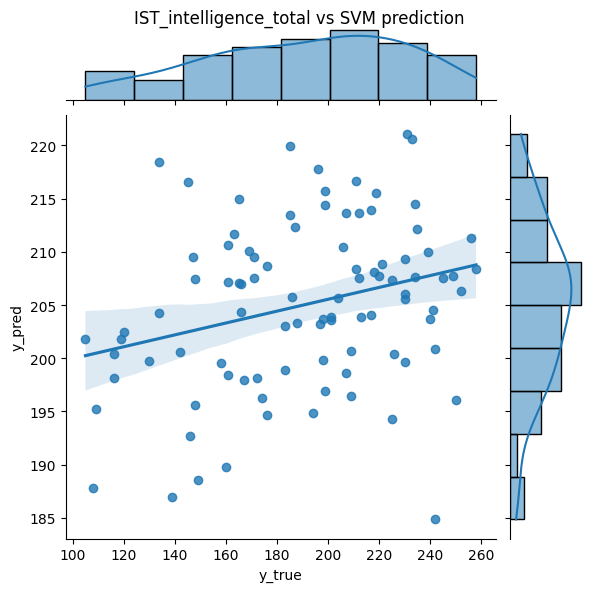

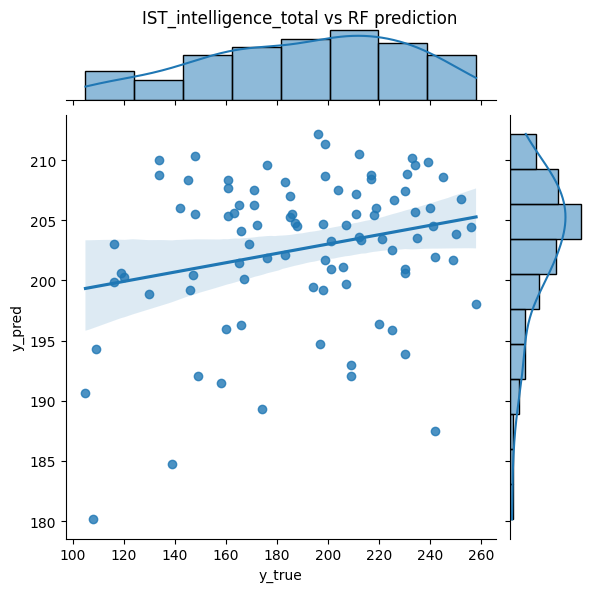

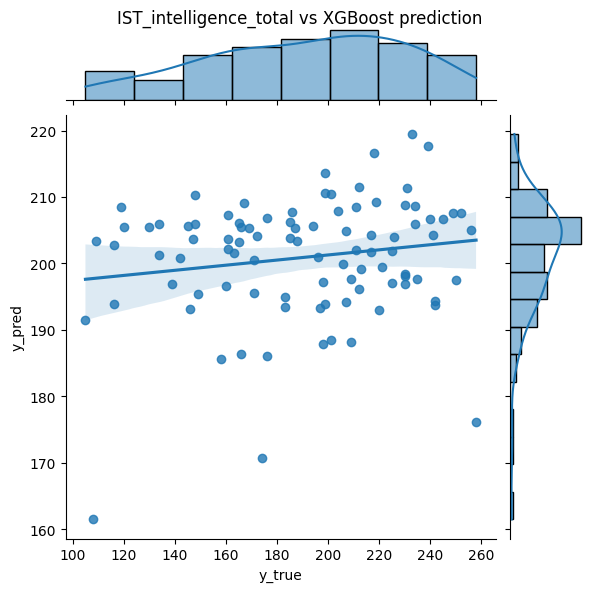

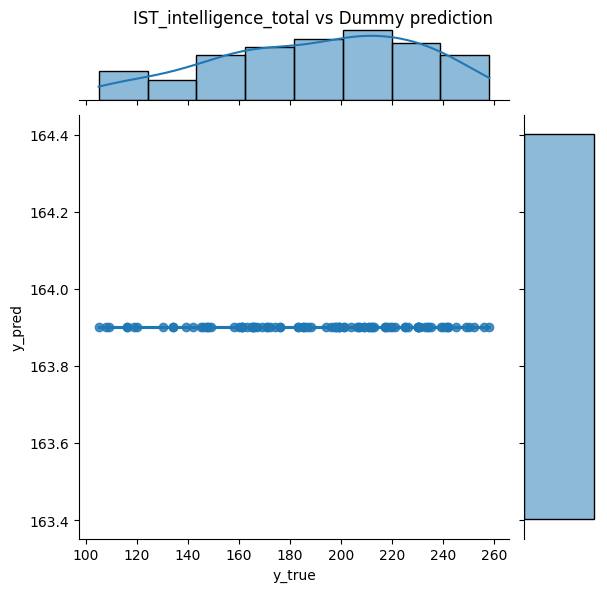

In [23]:
for i, m_name in enumerate(models.keys()):
    y_true = df_holdout['IST_intelligence_total']
    y_pred_fluid = model_dict['IST_fluid'][m_name].predict(df_holdout[X])
    y_pred_memory = model_dict['IST_memory'][m_name].predict(df_holdout[X])
    y_pred_crystallised = model_dict['IST_crystallised'][m_name].predict(df_holdout[X])

    y_pred = y_pred_fluid + y_pred_memory + y_pred_crystallised

    df_plot = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    j = sns.jointplot(data=df_plot, x="y_true", y="y_pred", kind="reg")
    plt.suptitle(f'IST_intelligence_total vs {m_name} prediction')
    j.fig.subplots_adjust(top=0.95)
    j.savefig(f'./svg/Shen/IST_total_vs_{m_name}_pred.svg')

In [31]:
for target, score_by_model_for_target in scores_dict.items():
    for model_name, score_for_model in score_by_model_for_target.items():
        score_for_model.to_csv(f'./scores/Shen/{target}_{model_name}.csv')

In [30]:
for i, m_name in enumerate(models.keys()):
    y_true_fluid = df_holdout['IST_fluid']
    y_true_crystallised = df_holdout['IST_crystallised']
    y_true_memory = df_holdout['IST_memory']
    y_pred_fluid = model_dict['IST_fluid'][m_name].predict(df_holdout[X])
    y_pred_crystallised = model_dict['IST_crystallised'][m_name].predict(df_holdout[X])
    y_pred_memory = model_dict['IST_memory'][m_name].predict(df_holdout[X])

    y_mae_fluid = np.mean(abs(y_true_fluid - y_pred_fluid))
    y_mae_crystallised = np.mean(abs(y_true_crystallised - y_pred_crystallised))
    y_mae_memory = np.mean(abs(y_true_memory - y_pred_memory))

    np.savetxt(f"shen_{m_name}_y_pred_fluid.csv", y_pred_fluid, delimiter=",")
    np.savetxt(f"shen_{m_name}_y_pred_crystallised.csv", y_pred_crystallised, delimiter=",")
    np.savetxt(f"shen_{m_name}_y_pred_memory.csv", y_pred_memory, delimiter=",")
    y_true_fluid.to_csv('shen_y_true_fluid.csv')
    y_true_crystallised.to_csv('shen_y_true_crystallised.csv')
    y_true_memory.to_csv('shen_y_true_memory.csv')

    print(f'===================== {m_name} =====================')
    print(f'IST_fluid MAE for {m_name}: {y_mae_fluid}')
    print(f'IST_fluid mean_pred for {m_name}: {np.mean(y_pred_fluid)}')
    print(f'IST_fluid std_pred for {m_name}: {np.std(y_pred_fluid)}')
    print('------------------------------------------')
    print(f'IST_crystallised MAE for {m_name}: {y_mae_crystallised}')
    print(f'IST_crystallised mean_pred for {m_name}: {np.mean(y_pred_crystallised)}')
    print(f'IST_crystallised std_pred for {m_name}: {np.std(y_pred_crystallised)}')
    print('------------------------------------------')
    print(f'IST_memory MAE for {m_name}: {y_mae_memory}')
    print(f'IST_memory mean_pred for {m_name}: {np.mean(y_pred_memory)}')
    print(f'IST_memory std_pred for {m_name}: {np.std(y_pred_memory)}')

===================== SVM =====================
IST_fluid MAE for SVM: 20.783632396699208
IST_fluid mean_pred for SVM: 109.55495967775079
IST_fluid std_pred for SVM: 4.588402147428429
------------------------------------------
IST_crystallised MAE for SVM: 7.742754719818841
IST_crystallised mean_pred for SVM: 39.935568625368134
IST_crystallised std_pred for SVM: 2.653124405008875
------------------------------------------
IST_memory MAE for SVM: 8.469266835394519
IST_memory mean_pred for SVM: 55.52508116835946
IST_memory std_pred for SVM: 1.6160613499824557
===================== RF =====================
IST_fluid MAE for RF: 20.828298594959456
IST_fluid mean_pred for RF: 107.84927803115623
IST_fluid std_pred for RF: 4.369836116163615
------------------------------------------
IST_crystallised MAE for RF: 7.777916819205103
IST_crystallised mean_pred for RF: 39.79905399977199
IST_crystallised std_pred for RF: 1.4335607935505805
------------------------------------------
IST_memory MAE fo

In [32]:
for y in targets:
    print(y)
    print(np.mean(df_full[y]))
    print(np.std(df_full[y]))

IST_fluid
107.47418967587035
25.901829974193745
IST_crystallised
39.639855942376954
10.263395298461262
IST_memory
54.63385354141656
8.895236955379861


In [25]:
df_holdout.to_csv('shen_holdout.csv')